# TiTiler-CMR: Statistics Benchmarking

This notebook shows how to benchmark the `/timeseries/statistics` endpoint of a TiTiler-CMR deployment and understand how performance varies under different parameters. 

In Titiler-CMR, the `/timeseries/statistics` endpoint computes statistics for all points/intervals along a timeseries and over a specified geometry. The performance of this endpoint can vary based on several factors that we will explore in this notebook.

-----------------------------------

**In this notebook, you'll learn**:

- How to benchmark the `/timeseries/statistics` endpoint across different parameters
- What factors impact the performance of the `/timeseries/statistics` endpoint in TiTiler-CMR
- Tips on how to use the endpoint effectively to avoid any timeouts or performance issues

In [1]:
import pandas as pd
import httpx
from geojson_pydantic import Feature, Polygon
import json

from datacube_benchmark.titiler_cmr_benchmark import (
    DatasetParams,
    benchmark_statistics,
    create_bbox_feature,
)

endpoint = "https://staging.openveda.cloud/api/titiler-cmr"

### Introduction

The `/timeseries/statistics` endpoint will produce summary statistics for an AOI for all points along a timeseries. This typically involves reading multiple granules, performing reprojection/resampling/mosaicking, and then computing statistics over the specified area of interest .

This endpoint returns a GeoJSON FeatureCollection with statistics for each time point in the timeseries.


The performance of this endpoint can vary based on several factors, including:
- The size and complexity of the geometry (e.g., a small polygon vs a large bounding box)
- The number of granules that need to be read and processed to cover the geometry
- The length of the time series (i.e., how many time points i.e. granules)


We want to define the parameters for the CMR dataset we want to benchmark. The `DatasetParams` class encapsulates all the necessary information to interact with a specific dataset via TiTiler-CMR.


In [2]:
concept_id = "C2723754864-GES_DISC"
backend = "xarray"
datetime_range = "2022-03-01T00:00:01Z/2022-03-01T23:59:59Z"
variable = "precipitation"
step = "P1D"
temporal_mode = "point"


ds_xarray = DatasetParams(
    concept_id=concept_id,
    backend=backend,
    datetime_range=datetime_range,
    variable=variable,
    step=step,
    temporal_mode=temporal_mode,
)



### GeoJson Feature

The `/timeseries/statistics` endpoint requires a GeoJSON `Feature` or `FeatureCollection` to define the area over which statistics will be computed.

The `create_bbox_feature` function can be used to create a bounding box feature.


`benchmark_statistics` is a wrapper function that runs the benchmark for the `/timeseries/statistics` endpoint and returns a DataFrame with the results including the statistics computed and the time taken for each request.

Here is an example of how to use it:

In [3]:
gulf_geometry = create_bbox_feature(-98.676, 18.857, -81.623, 31.097)
stats_result = await benchmark_statistics(
    endpoint=endpoint,
    dataset=ds_xarray,
    geometry=gulf_geometry,
    timeout_s=300.0,
)
print("Statistics result:")
print(f"  Success: {stats_result['success']}")
print(f"  Elapsed: {stats_result['elapsed_s']:.2f}s")
print(f"  Timesteps: {stats_result['n_timesteps']}")


=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Statistics result:
  Success: True
  Elapsed: 1.74s
  Timesteps: 1


You can also access the statistics output from the endpoint easily: `stats_result['statistics']`

In [4]:
print(f"  Statistics:")
print (json.dumps(stats_result['statistics'], indent=2))

  Statistics:
{
  "2022-03-01T00:00:01+00:00": {
    "2022-03-01T00:00:00.000000000": {
      "min": 0.0,
      "max": 42.82999801635742,
      "mean": 0.3393020033836365,
      "count": 20898.5,
      "sum": 7090.90283203125,
      "std": 1.9955874881629714,
      "median": 0.0,
      "majority": 0.0,
      "minority": 0.044999994337558746,
      "unique": 1347.0,
      "histogram": [
        [
          20614,
          232,
          65,
          46,
          20,
          19,
          14,
          16,
          4,
          3
        ],
        [
          0.0,
          4.2829999923706055,
          8.565999984741211,
          12.848999977111816,
          17.131999969482422,
          21.415000915527344,
          25.697999954223633,
          29.980998992919922,
          34.263999938964844,
          38.547000885009766,
          42.82999801635742
        ]
      ],
      "valid_percent": 100.0,
      "masked_pixels": 0.0,
      "valid_pixels": 21033.0,
      "percentile_2

The statistics results typically include several useful metrics for all points/intervals along a timeseries:
- min, max, mean, count, sum
- valid pixels, masked pixels, valid percentage
- percentiles (e.g., 98th percentile), data distribution histogram, unique values, median, std

Now, we want to test how the size of the geometry affects performance. We’ll use square bounding boxes centered on a chosen point and increase the edge length (degrees) to see how it impacts the response time. 


In [5]:
def bbox_square_feature(center_lon: float, center_lat: float, edge_deg: float):
    """
    Build a square bbox Feature of size edge_deg × edge_deg centered at (lon, lat).
    """
    half = edge_deg / 2.0
    min_lon, min_lat = center_lon - half, center_lat - half
    max_lon, max_lat = center_lon + half, center_lat + half
    return create_bbox_feature(min_lon, min_lat, max_lon, max_lat)

center_lon, center_lat = -95.0, 29.0  # Houston-ish
edge_sizes_deg = [0.1, 0.5, 1, 5.0, 10.0, 15.0, 20.0, ]  # caution: large areas may time out for high-res products


In [6]:
geom = bbox_square_feature(center_lon, center_lat, 2)
stats_result = await benchmark_statistics(
    endpoint=endpoint,
    dataset=ds_xarray,
    geometry=geom,
    timeout_s=300.0,
)
print("Statistics result:")
print(f"  Success: {stats_result['success']}")
print(f"  Elapsed: {stats_result['elapsed_s']:.2f}s")
print(f"  Timesteps: {stats_result['n_timesteps']}")
print(f"  Statistics: {stats_result['statistics']}")

=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Statistics result:
  Success: True
  Elapsed: 1.34s
  Timesteps: 1
  Statistics: {'2022-03-01T00:00:01+00:00': {'2022-03-01T00:00:00.000000000': {'min': 0.0, 'max': 0.07999999821186066, 'mean': 0.0004625000001396984, 'count': 400.0, 'sum': 0.1850000023841858, 'std': 0.004896283380458125, 'median': 0.0, 'majority': 0.0, 'minority': 0.004999999888241291, 'unique': 7.0, 'histogram': [[395, 2, 0, 1, 0, 1, 0, 0, 0, 1], [0.0, 0.007999999448657036, 0.01599999889731407, 0.023999998345971107, 0.03199999779462814, 0.03999999910593033, 0.047999996691942215, 0.0559999942779541, 0.06399999558925629, 0.07199999690055847, 0.07999999821186066]], 'valid_percent': 100.0, 'masked_pixels': 20.0, 'valid_pixels': 400.0, 'percentile_2': 0.0, 'percentile_98': 0.0}}}


In [7]:
geom = bbox_square_feature(center_lon, center_lat, 10)
stats_result = await benchmark_statistics(
    endpoint=endpoint,
    dataset=ds_xarray,
    geometry=geom,
    timeout_s=300.0,
)
print("Statistics result:")
print(f"  Success: {stats_result['success']}")
print(f"  Elapsed: {stats_result['elapsed_s']:.2f}s")
print(f"  Timesteps: {stats_result['n_timesteps']}")
print(f"  Statistics: {stats_result['statistics']}")

=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Statistics result:
  Success: True
  Elapsed: 1.28s
  Timesteps: 1
  Statistics: {'2022-03-01T00:00:01+00:00': {'2022-03-01T00:00:00.000000000': {'min': 0.0, 'max': 3.1050000190734863, 'mean': 0.018581999465823174, 'count': 10000.0, 'sum': 185.8199920654297, 'std': 0.10929711157096253, 'median': 0.0, 'majority': 0.0, 'minority': 0.029999997466802597, 'unique': 217.0, 'histogram': [[9812, 114, 37, 24, 6, 4, 1, 1, 0, 1], [0.0, 0.31049999594688416, 0.6209999918937683, 0.9314999580383301, 1.2419999837875366, 1.5525000095367432, 1.8629999160766602, 2.1735000610351562, 2.4839999675750732, 2.7944998741149902, 3.1050000190734863]], 'valid_percent': 100.0, 'masked_pixels': 100.0, 'valid_pixels': 10000.0, 'percentile_2': 0.0, 'percentile_98': 0.29499998688697815}}}


In [8]:
geom = bbox_square_feature(center_lon, center_lat, 20)
stats_result = await benchmark_statistics(
    endpoint=endpoint,
    dataset=ds_xarray,
    geometry=geom,
    timeout_s=300.0,
)
print("Statistics result:")
print(f"  Success: {stats_result['success']}")
print(f"  Elapsed: {stats_result['elapsed_s']:.2f}s")
print(f"  Timesteps: {stats_result['n_timesteps']}")
print(f"  Statistics: {stats_result['statistics']}")

=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Statistics result:
  Success: True
  Elapsed: 3.19s
  Timesteps: 1
  Statistics: {'2022-03-01T00:00:01+00:00': {'2022-03-01T00:00:00.000000000': {'min': 0.0, 'max': 42.82999801635742, 'mean': 0.15982724726200104, 'count': 40000.0, 'sum': 6393.08984375, 'std': 1.4203556033267632, 'median': 0.0, 'majority': 0.0, 'minority': 0.044999994337558746, 'unique': 1181.0, 'histogram': [[39645, 181, 53, 45, 20, 19, 14, 16, 4, 3], [0.0, 4.2829999923706055, 8.565999984741211, 12.848999977111816, 17.131999969482422, 21.415000915527344, 25.697999954223633, 29.980998992919922, 34.263999938964844, 38.547000885009766, 42.82999801635742]], 'valid_percent': 100.0, 'masked_pixels': 200.0, 'valid_pixels': 40000.0, 'percentile_2': 0.0, 'percentile_98': 1.3799999952316284}}}


Now, let's run the benchmark for each geometry size and collect the results.


In [9]:
async def run_stats_benchmark_for_sizes(
    ds: DatasetParams,
    edge_sizes:[],
    *,
    endpoint: str,
    center_lon: float,
    center_lat: float,
    timeout_s: float = 180.0,
) -> pd.DataFrame:
    rows = []
    for edge in edge_sizes:
        geom = bbox_square_feature(center_lon, center_lat, edge)
        out = await benchmark_statistics(
            endpoint=endpoint,
            dataset=ds,
            geometry=geom,
            timeout_s=timeout_s,
        )
        rows.append({
            "backend": ds.backend,
            "concept_id": ds.concept_id,
            "edge_deg": edge,
            "success": out.get("success", False),
            "status_code": out.get("status_code", None),
            "elapsed_s": out.get("elapsed_s", None),
            "n_timesteps": out.get("n_timesteps", 0),
        })
    return pd.DataFrame(rows)

In [10]:
df_xr  = await run_stats_benchmark_for_sizes(ds_xarray,  edge_sizes_deg, endpoint=endpoint, center_lon=center_lon, center_lat=center_lat, timeout_s=180.0)

df_xr


=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)


,backend,concept_id,edge_deg,success,status_code,elapsed_s,n_timesteps
0,xarray,C2723754864-GES_DISC,0.1,True,200,1.604297,1
1,xarray,C2723754864-GES_DISC,0.5,True,200,1.696259,1
2,xarray,C2723754864-GES_DISC,1.0,True,200,1.322251,1
3,xarray,C2723754864-GES_DISC,5.0,True,200,1.624505,1
4,xarray,C2723754864-GES_DISC,10.0,True,200,1.140307,1
5,xarray,C2723754864-GES_DISC,15.0,True,200,3.155293,1
6,xarray,C2723754864-GES_DISC,20.0,True,200,1.930063,1


> **Tip**: If you see timeouts or failures at larger sizes, try smaller AOIs first and/or choose a coarser step.

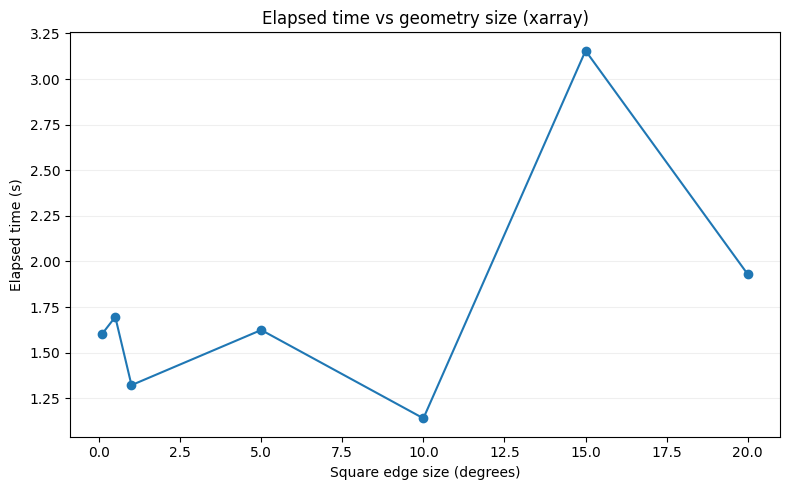

In [11]:
import matplotlib.pyplot as plt
def plot_elapsed_vs_size(df: pd.DataFrame, *, title: str = "Elapsed time vs geometry size (xarray)"):
    sdf = df.copy()
    sdf = sdf[pd.notnull(sdf["elapsed_s"])].sort_values("edge_deg")


    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(sdf["edge_deg"], sdf["elapsed_s"], marker="o")
    ax.set_xlabel("Square edge size (degrees)")
    ax.set_ylabel("Elapsed time (s)")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.2)
    plt.tight_layout()
    return fig, ax


_ = plot_elapsed_vs_size(df_xr)
plt.show()

### Time Range 
For statics benchmarking, the number of timesteps matters too. Longer time series (more timesteps) will generally take longer to process. This sweep varies the time window length (number of timesteps) while keeping the geometry size constant to see how that affects performance.



In [12]:
##daily 10 days
# Xarray example (e.g., GES_DISC variable)
ds_xarray = DatasetParams(
    concept_id="C2723754864-GES_DISC",
    backend="xarray",
    datetime_range="2022-03-01T00:00:01Z/2022-03-10T23:59:59Z",
    variable="precipitation",
    step="P1W",
    temporal_mode="point",
)

gulf_geometry = create_bbox_feature(-98.676, 18.857, -81.623, 31.097)
stats_result = await benchmark_statistics(
    endpoint=endpoint,
    dataset=ds_xarray,
    geometry=gulf_geometry,
    timeout_s=300.0,
)
print("Statistics result:")
print(f"  Success: {stats_result['success']}")
print(f"  Elapsed: {stats_result['elapsed_s']:.2f}s")
print(f"  Timesteps: {stats_result['n_timesteps']}")
print(f"  Statistics: {stats_result['statistics']}")

=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Statistics result:
  Success: True
  Elapsed: 13.50s
  Timesteps: 2
  Statistics: {'2022-03-01T00:00:01+00:00': {'2022-03-01T00:00:00.000000000': {'min': 0.0, 'max': 42.82999801635742, 'mean': 0.3393020033836365, 'count': 20898.5, 'sum': 7090.90283203125, 'std': 1.9955874881629714, 'median': 0.0, 'majority': 0.0, 'minority': 0.044999994337558746, 'unique': 1347.0, 'histogram': [[20614, 232, 65, 46, 20, 19, 14, 16, 4, 3], [0.0, 4.2829999923706055, 8.565999984741211, 12.848999977111816, 17.131999969482422, 21.415000915527344, 25.697999954223633, 29.980998992919922, 34.263999938964844, 38.547000885009766, 42.82999801635742]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 21033.0, 'percentile_2': 0.0, 'percentile_98': 4.244999885559082}}, '2022-03-08T00:00:01+00:00': {'2022-03-08T00:00:00.000000000': {'min': 0.0, 'max': 42.36000061035156, 'me

In [13]:
##daily 50 days
# Xarray example (e.g., GES_DISC variable)
ds_xarray = DatasetParams(
    concept_id="C2723754864-GES_DISC",
    backend="xarray",
    datetime_range="2022-03-01T00:00:01Z/2022-04-20T23:59:59Z",
    variable="precipitation",
    step="P1W",
    temporal_mode="point",
)

gulf_geometry = create_bbox_feature(-98.676, 18.857, -81.623, 31.097)
stats_result = await benchmark_statistics(
    endpoint=endpoint,
    dataset=ds_xarray,
    geometry=gulf_geometry,
    timeout_s=300.0,
)
print("Statistics result:")
print(f"  Success: {stats_result['success']}")
print(f"  Elapsed: {stats_result['elapsed_s']:.2f}s")
print(f"  Timesteps: {stats_result['n_timesteps']}")
print(f"  Statistics: {stats_result['statistics']}")

=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Statistics result:
  Success: True
  Elapsed: 22.99s
  Timesteps: 8
  Statistics: {'2022-03-01T00:00:01+00:00': {'2022-03-01T00:00:00.000000000': {'min': 0.0, 'max': 42.82999801635742, 'mean': 0.3393020033836365, 'count': 20898.5, 'sum': 7090.90283203125, 'std': 1.9955874881629714, 'median': 0.0, 'majority': 0.0, 'minority': 0.044999994337558746, 'unique': 1347.0, 'histogram': [[20614, 232, 65, 46, 20, 19, 14, 16, 4, 3], [0.0, 4.2829999923706055, 8.565999984741211, 12.848999977111816, 17.131999969482422, 21.415000915527344, 25.697999954223633, 29.980998992919922, 34.263999938964844, 38.547000885009766, 42.82999801635742]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 21033.0, 'percentile_2': 0.0, 'percentile_98': 4.244999885559082}}, '2022-03-08T00:00:01+00:00': {'2022-03-08T00:00:00.000000000': {'min': 0.0, 'max': 42.36000061035156, 'me

In [14]:
## 

## Conclusion

In this notebook, we explored how to benchmark the `/timeseries/statistics` endpoint of a TiTiler-CMR deployment. We examined how different parameters, such as geometry size and time range, impact the performance of this endpoint.

We found that larger geometries and longer time ranges generally lead to increased processing times. 

In general, for high-resolution datasets with many granules, it's advisable to use smaller AOIs and shorter time ranges to ensure timely responses and avoid timeouts.


### Further Reading
- [TiTiler-CMR GitHub Repository](https://github.com/cogeotiff/titiler-cmr)
- [Titiler-CMR API Documentation](https://staging.openveda.cloud/api/titiler-cmr/api.html#/)
- [Earthdata Cloud CMR Datasets](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#datasets)
